# INTRODUCTION

This study aims to classify online shoppers' purchasing behavior using the Online Shoppers Intention __[Kaggle](https://www.kaggle.com/datasets/henrysue/online-shoppers-intention)__ dataset. This dataset consists of 18 features, including 10 numerical and 8 categorical attributes. The primary goal is to predict whether a customer made a purchase (purchase or no purchase) based on their browsing behavior and website interaction characteristics.

__References:__
* [Ref #1](https://medium.com/analytics-vidhya/marketing-analytics-significance-of-feature-engineering-model-selection-and-hyper-parameter-53d34b57bc55)
* [Ref #2](https://github.com/Charlotte-1987/openclassroomP7/blob/main/P7_MODELLING_STREAMLIT_VF.ipynb)

# I. Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling Evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)

# Metric
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score, roc_curve, auc,
    fbeta_score, make_scorer
)

# Modelling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

 
from sklearn.decomposition import PCA

# User defined functions / modules
from marketing_functions import *

# Utilities
# import shap
import time
import warnings

In [2]:
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
print("Importing Librarires and Setup complete.")

Importing Librarires and Setup complete.


In [3]:
# Seaborn options
sns.set(style="darkgrid")
sns.set_color_codes("muted")

# II. Input the Data

In [4]:
#Reading the input data
customer = pd.read_csv("market_response_cleaned.csv")
target_column = "purchase"
customer.head()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,purchase
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
customer.shape

(12330, 18)

# II. Model: Python Class

In [6]:
class FeatureClassifier:
    """
    A class for classification tasks with feature preprocessing, importance analysis, and grid search.

    Attributes:
        categorical_features (list): List of categorical feature names.
        numerical_features (list): List of numerical feature names.
        best_estimator_ (object): The best performing classifier from grid search (if performed).
        best_score_ (float): The best score achieved by the best estimator (if performed).
        pipeline (Pipeline): Pipeline object for best performing classifier and preprocessing.
        feature_names (list): List of transformed feature names (after fitting).

    Methods:
        fit(X_train, y_train, classifiers=None, param_grid=None):
            Fits the classifier to the training data and performs grid search (if parameters provided).
        predict(X_test): Predicts class labels for test data.
        get_feature_importance(X_test=None): 
            Calculates and returns feature importances (if X_test provided).
        plot_feature_importance(X_test=None): 
            Plots the feature importances using Seaborn (if X_test provided).
    """

    def __init__(self, categorical_features, numerical_features, **kwargs):
        """
        Initializes the classifier with feature lists.

        Args:
            categorical_features (list): List of categorical feature names.
            numerical_features (list): List of numerical feature names.
        """

        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
         
        # Define transformers
        self.categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

        self.numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            #('scaler', MinMaxScaler(feature_range = (0, 1)))
        ])      

        # Create a column transformer
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('cat', self.categorical_transformer, self.categorical_features),
                ('num', self.numerical_transformer, self.numerical_features)
            ])

        
        self.feature_names = None  # Initialize as None, update after fitting         
        self.kwargs = kwargs

    
    def fit(self, X_train, y_train, classifer_name=None, classifier=None, param_grid= None, 
            param_grid_flag=None, feature_engineering_method=None, scoring_metric="accuracy", 
            cv=5, pca_components=5):
        """
        Fits the classifier to the training data and performs grid search (if parameters provided).

        Args:
            X_train (pd.DataFrame): Training data features.
            y_train (pd.Series): Training data labels.
            classifiers_grid_param  (dict, optional): Dictionary of name, classifier classes and 
                hyperparameter grids for each classifier to evaluate (default: None).
            If None, uses default classifiers.
        """
        print(f"{classifer_name=}; {classifier=}; {param_grid=}")
        # Add classifiers and grid search 
        results = {}        

        steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', classifier)
        ]
        
        if feature_engineering_method == 'pca': 
            n_components =  pca_components
            steps.insert(1, ('pca', PCA(n_components=n_components)))        
        
        # Create a pipeline with preprocessor and classifier
        pipeline = Pipeline(steps=steps)

        self.pipeline = pipeline

        # Get the all the feature names for feature importance analysis
        all_feature_names = pd.DataFrame(self.preprocessor.fit_transform(X_train), 
                               columns=self.preprocessor.get_feature_names_out(), 
                               index=X_train.index)
        feature_names = all_feature_names.columns.tolist()
        self.feature_names = feature_names
       

        # Grid search if grid parameters are provided
        
        if param_grid_flag:
            print("YES grid search performed.")
            grid_search = GridSearchCV(estimator=pipeline,
                                      param_grid=param_grid,
                                      cv=cv,
                                      verbose=0,
                                      n_jobs=-1,
                                      scoring=scoring_metric,
                                      error_score="raise",
                                       refit=True)
            start_time = time.time()
            best_model = grid_search.fit(X_train, y_train)
            fit_time = time.time() - start_time
        else:
            # If no grid parameters, fit the pipeline directly
            print("No grid search performed.")
            start_time = time.time()
            best_model = pipeline.fit(X_train, y_train)
            fit_time = time.time() - start_time
            
        return best_model, fit_time

            

### Split the dataset into train and test sets

In [7]:
target_column = "purchase"
categorical_features = ["operating_systems", "browser", "region", "traffic_type", "visitor_type", 'special_day', "month", "weekend"]
numerical_features = customer.drop([target_column], axis=1).columns.difference(categorical_features)
customer[target_column].value_counts(normalize = True).round(2)

purchase
False    0.85
True     0.15
Name: proportion, dtype: float64

In [8]:
# Split data into features and target
stratify_target = True
test_size = 0.2
X = customer.drop(columns=[target_column])
y = customer[target_column]

# Identify potential problematic features (replace with your actual feature names)
possible_problem_features = ['month', 'visitor_type']  # Replace with actual feature names

# Preprocess numerical features (assuming they might have string values)
from sklearn.preprocessing import LabelEncoder

for feature in possible_problem_features:
    if X[feature].dtype == object:  # Check if feature is object type (string)
        le = LabelEncoder()
        X[feature] = le.fit_transform(X[feature])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                  stratify=y if stratify_target else None,
                                                  random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9864, 17), (2466, 17), (9864,), (2466,))

In [12]:
# Define a dictionary of hyperparameter grids for grid search (optional)
important_features = True
classifiers_grid_param = {
            'DummyClassifier': (DummyClassifier(), {}),
            'RandomForestClassifier': (RandomForestClassifier(random_state=42), {'classifier__n_estimators': [50, 100, 150]}),
            'GradientBoostingClassifier': (GradientBoostingClassifier(random_state=42), {'classifier__n_estimators': [50, 100, 150]}),
            'LogisticRegression': (LogisticRegression(), {'classifier__C': [0.1, 1, 10]}),
            'SVC': (SVC(probability=True), {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}),
            'KNeighborsClassifier': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7]}),
            'BernoulliNB': (GaussianNB(), {'classifier__var_smoothing': np.logspace(0, -9, num=10)}),
            'DecisionTreeClassifier': (DecisionTreeClassifier(), {'classifier__max_depth': [None, 10, 20]}),
            'XGBClassifier': (XGBClassifier(), {'classifier__n_estimators': [50, 100, 150], 'classifier__learning_rate' : [0.01, 0.05, 0.10, 0.50, 1]}),
            'LGBMClassifier': (LGBMClassifier(), {})
}

In [13]:
# Create the FeatureClassifier object
clf = FeatureClassifier(categorical_features, numerical_features)

classifer_name='DummyClassifier'; classifier=DummyClassifier(); param_grid={}
YES grid search performed.
GridSearchCV
score train: 0.8453, score test: 0.8451
Accuracy Score 0.8450932684509327
Precision Score 0.0
Recall Score 0.0
F1 Score 0.0
time: 0.935065746307373


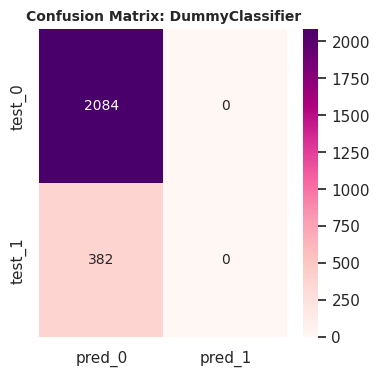

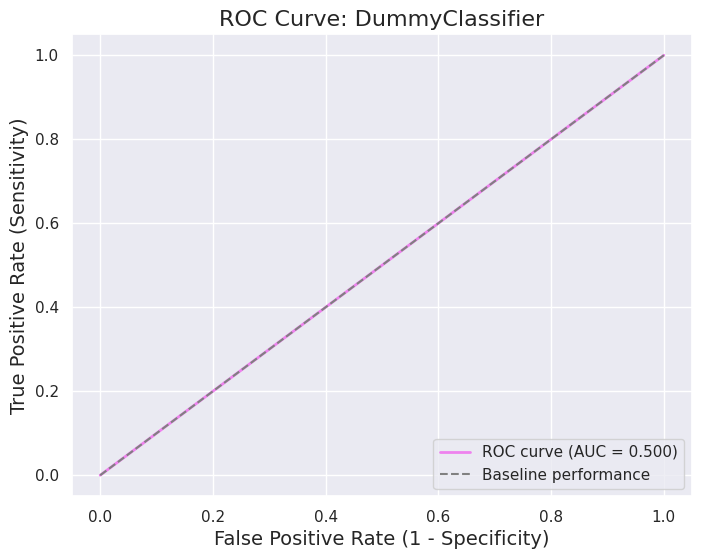

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

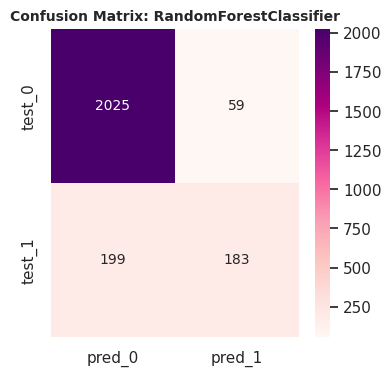

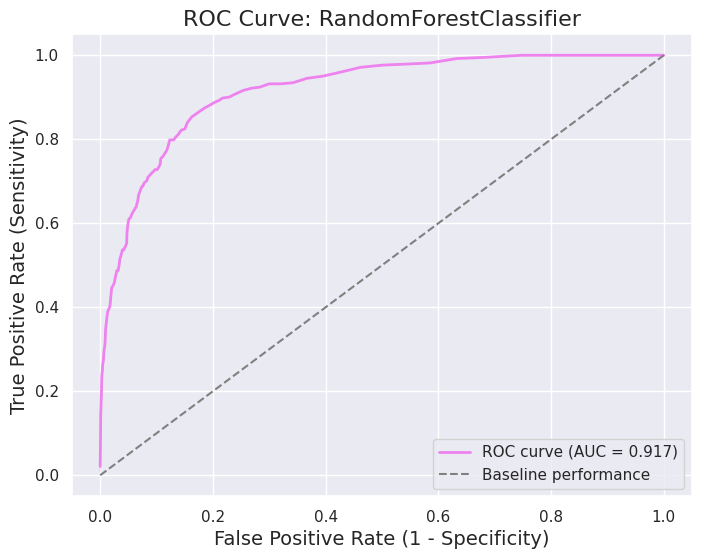

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

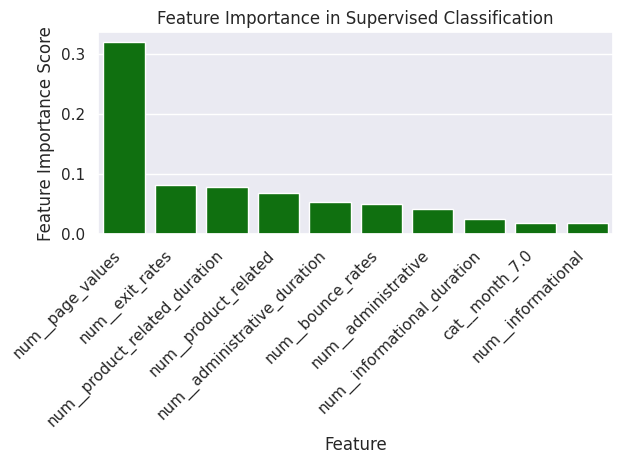

fit_time=3.9394729137420654


classifer_name='GradientBoostingClassifier'; classifier=GradientBoostingClassifier(random_state=42); param_grid={'classifier__n_estimators': [50, 100, 150]}
YES grid search performed.
GridSearchCV
score train: 0.915, score test: 0.9019
Accuracy Score 0.9018653690186537
Precision Score 0.7215189873417721
Recall Score 0.5968586387434555
F1 Score 0.653295128939828
time: 8.11735224723816


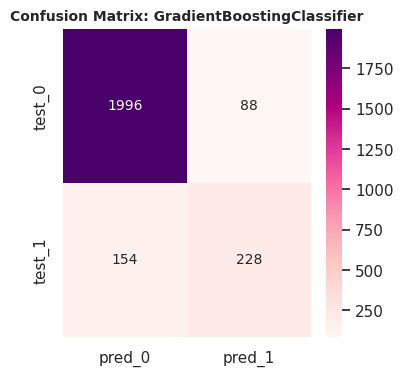

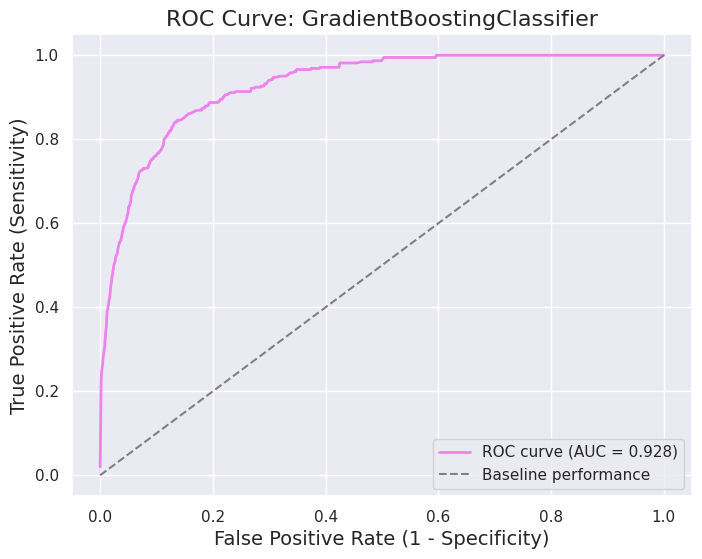

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

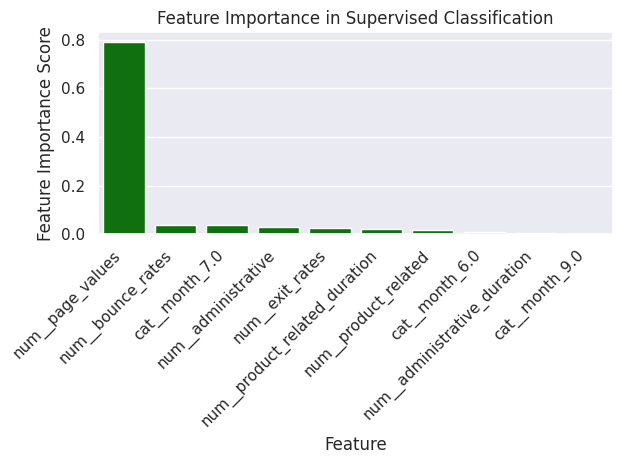

fit_time=8.11735224723816


classifer_name='LogisticRegression'; classifier=LogisticRegression(); param_grid={'classifier__C': [0.1, 1, 10]}
YES grid search performed.
GridSearchCV
score train: 0.8865, score test: 0.8804
Accuracy Score 0.8803730738037308
Precision Score 0.732620320855615
Recall Score 0.3586387434554974
F1 Score 0.48154657293497366
time: 0.9628291130065918


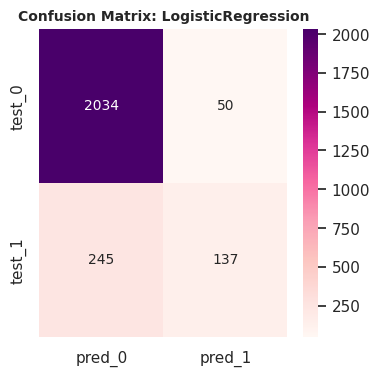

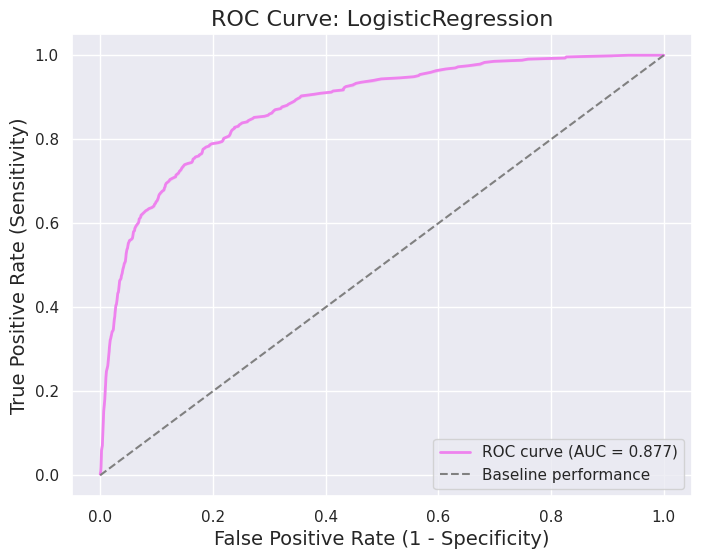

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

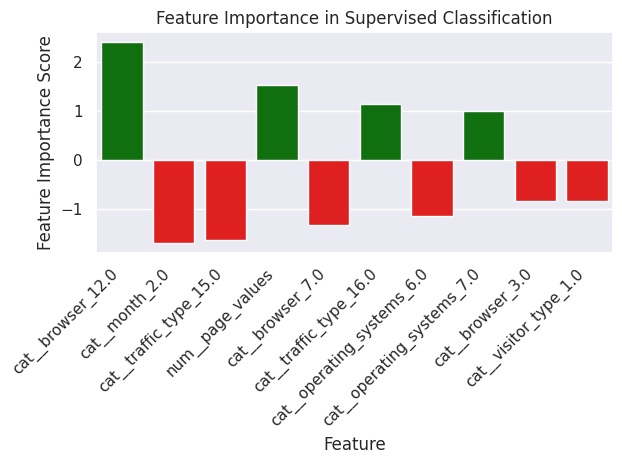

fit_time=0.9628291130065918


classifer_name='SVC'; classifier=SVC(probability=True); param_grid={'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}
YES grid search performed.
GridSearchCV
score train: 0.9106, score test: 0.8901
Accuracy Score 0.8901054339010543
Precision Score 0.7193675889328063
Recall Score 0.47643979057591623
F1 Score 0.5732283464566928
time: 162.11310172080994


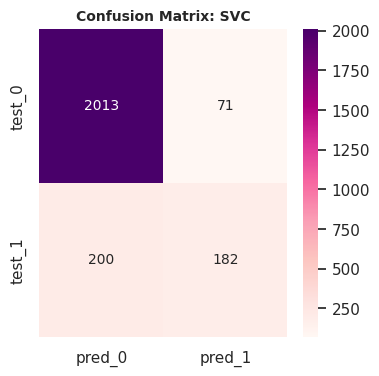

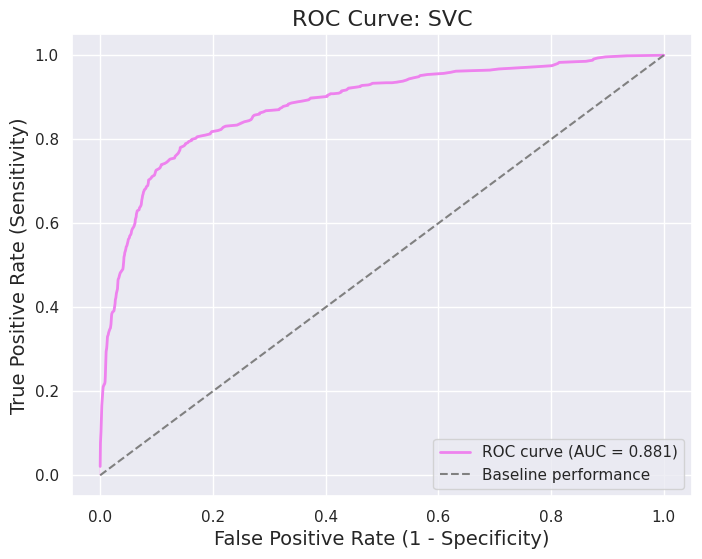

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

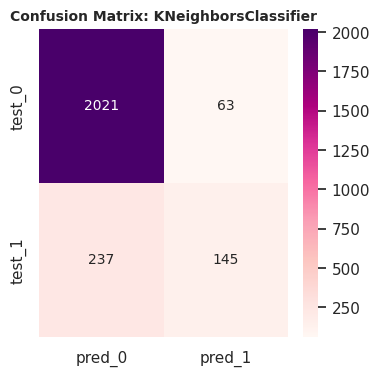

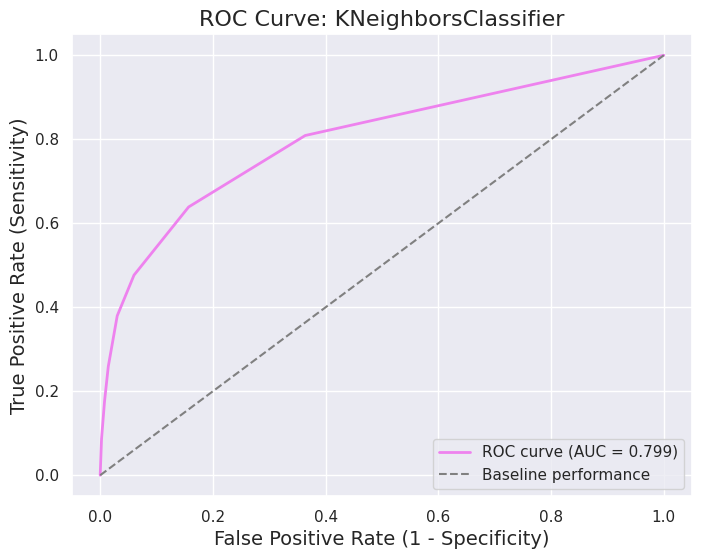

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

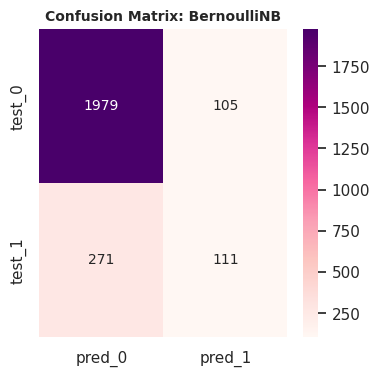

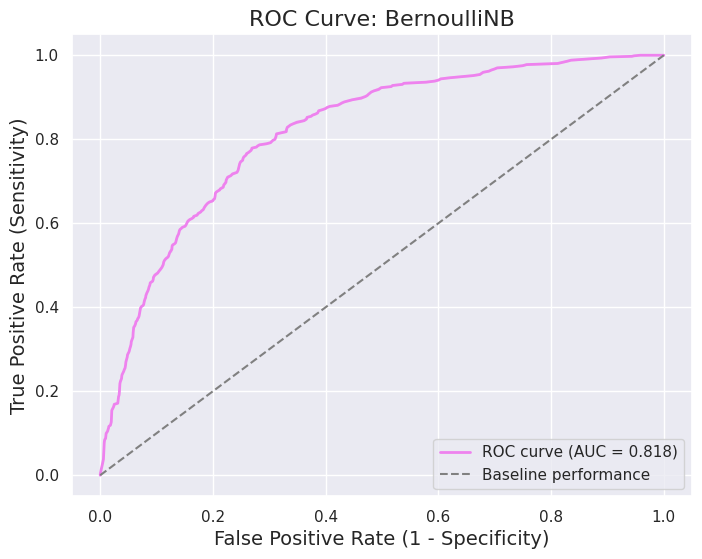

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

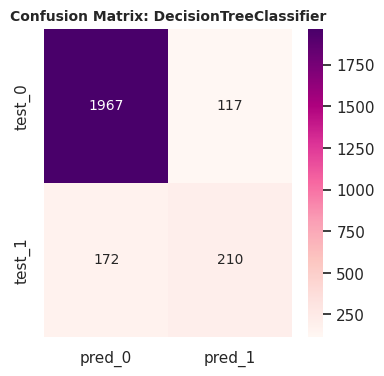

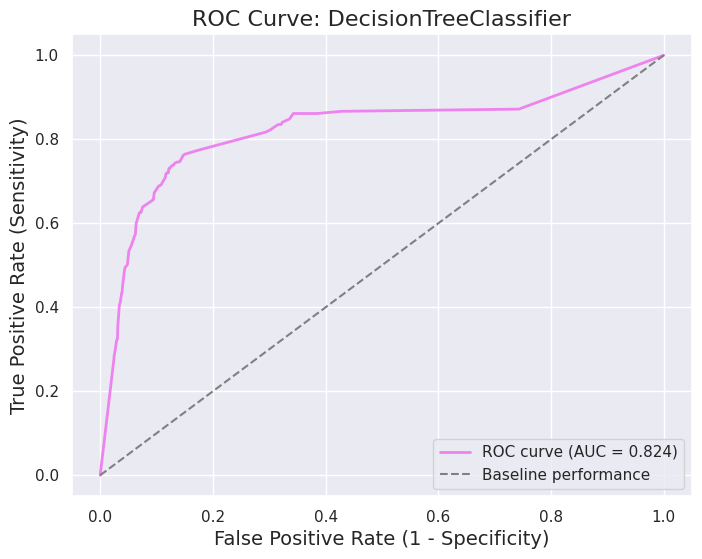

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

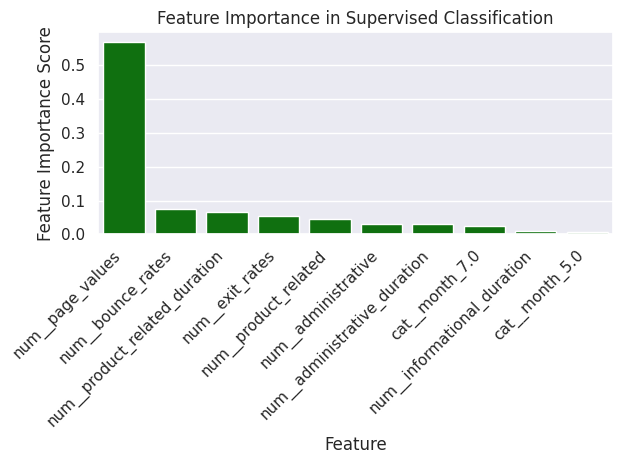

fit_time=0.4007728099822998


classifer_name='XGBClassifier'; classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...); param_grid={'classifier__n_estimators': [50, 100, 150], 'classifier__learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}
YES grid search performed.
GridSearchCV
score train: 0.9

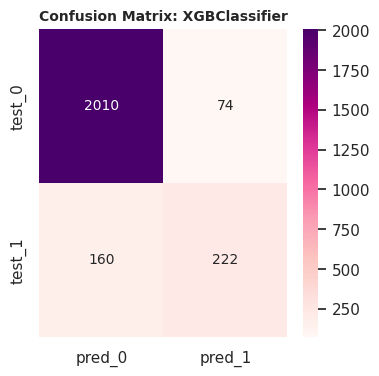

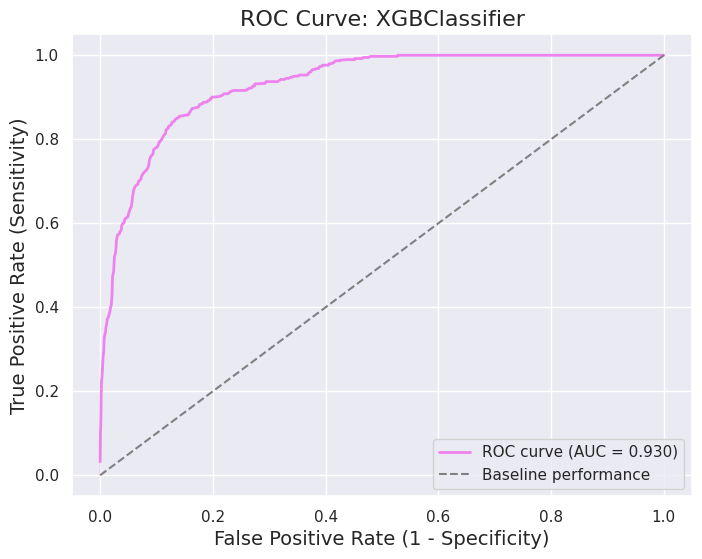

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

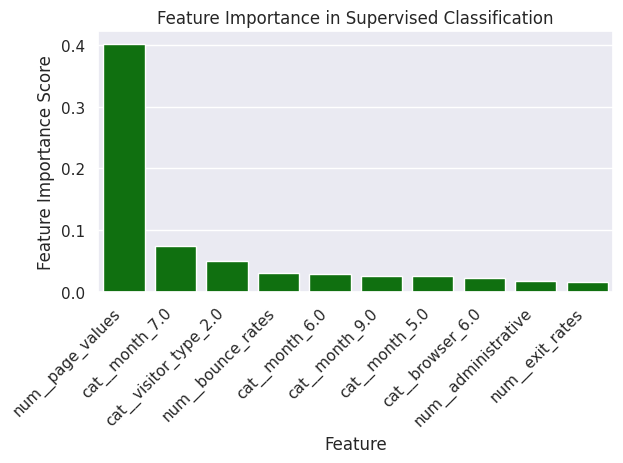

fit_time=4.071643829345703


classifer_name='LGBMClassifier'; classifier=LGBMClassifier(); param_grid={}
YES grid search performed.
[LightGBM] [Info] Number of positive: 1526, number of negative: 8338
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 9864, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154704 -> initscore=-1.698173
[LightGBM] [Info] Start training from score -1.698173
GridSearchCV
score train: 0.9619, score test: 0.9006
Accuracy Score 0.9006488240064883
Precision Score 0.7216828478964401
Recall Score 0.5837696335078534
F1 Score 0.6454413892908827
time: 155.4728343486786


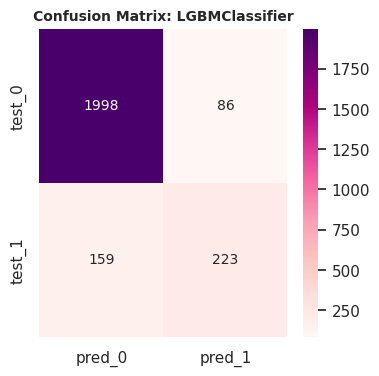

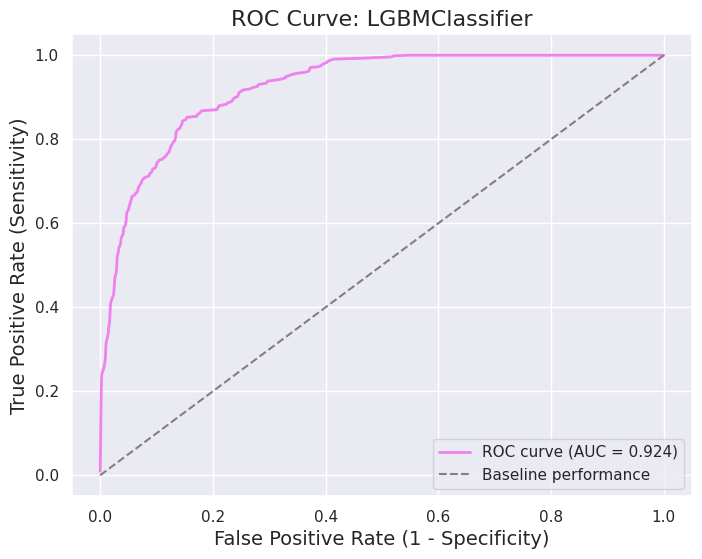

Best Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['operating_systems',
                                                   'browser', 'region',
                                                   'traffic_type',
                                                   'visitor_type',
                                                   'special_day', 'month',
                                                   'weekend']),
        

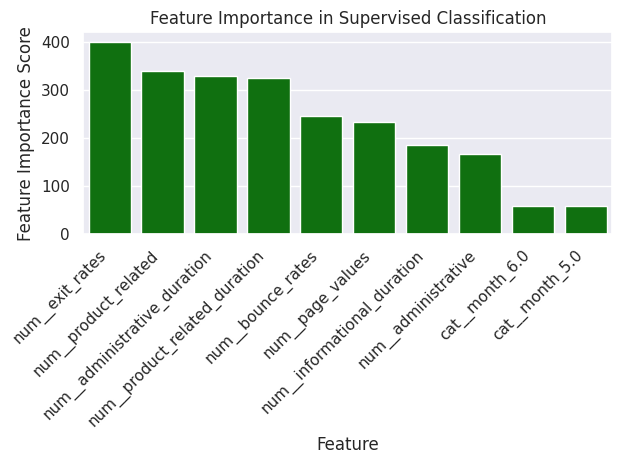

fit_time=155.4728343486786




In [14]:
# Fit the classifier with grid search
classifer_results = {}
for classifer_name, (classifier, param_grid) in classifiers_grid_param.items():
    best_model, fit_time = clf.fit(X_train, y_train, classifer_name=classifer_name, 
                                   classifier=classifier, param_grid= param_grid, param_grid_flag=True,
                                   feature_engineering_method=None,
                                   scoring_metric="accuracy", cv=5,pca_components=5
                                  )
    
    test_scores = score_classifier(best_model, X_train, X_test, y_train, y_test, fit_time=fit_time)
    classifer_results[classifer_name] = test_scores

    y_pred = best_model.predict(X_test)
    mat_values_dict = plot_confusion_matrix(y_test, y_predicted=y_pred, title=f"Confusion Matrix: {classifer_name}", 
                                            figsize=(4, 4), cmap="RdPu", annot=True, fmt="d", annot_kws={"size": 10})
    classifer_results[classifer_name].update(mat_values_dict)


    auc_score = plot_roc_auc_curve_seaborn(best_model, X_test, y_test, title=f"ROC Curve: {classifer_name}")
    classifer_results[classifer_name].update(auc_score)
    
    print(f"Best Estimator:\n{best_model.best_estimator_}")
    print(f"Best Parameters:\n{best_model.best_params_}")
    print(f"Best Test Score:\n{best_model.best_score_}")
    if important_features:
        feature_names = clf.feature_names
        best_estimator = best_model.best_estimator_
        get_feature_importance_scores(best_estimator=best_estimator, estimator_name="classifier", feature_names=feature_names, n_top_features=10)
    print(f"{fit_time=}\n\n")

classifer_results_df = pd.DataFrame(classifer_results).T
#display(classifer_results_df)

In [16]:
classifer_results_df.sort_values(by="F1 Score", ascending=False)

,Accuracy Score,Precision Score,Recall Score,F1 Score,true_pos,true_neg,false_pos,false_neg,auc
XGBClassifier,0.905109,0.750000,0.581152,0.654867,222.0,2010.0,74.0,160.0,0.930355
GradientBoostingClassifier,0.901865,0.721519,0.596859,0.653295,228.0,1996.0,88.0,154.0,0.928250
LGBMClassifier,0.896594,0.695385,0.591623,0.639321,226.0,1985.0,99.0,156.0,0.925600
DecisionTreeClassifier,0.883617,0.646154,0.549738,0.594059,210.0,1969.0,115.0,172.0,0.826326
RandomForestClassifier,0.895783,0.757202,0.481675,0.588800,184.0,2025.0,59.0,198.0,0.916814
SVC,0.880373,0.727749,0.363874,0.485166,139.0,2032.0,52.0,243.0,0.880970
LogisticRegression,0.879157,0.738636,0.340314,0.465950,130.0,2038.0,46.0,252.0,0.874023
KNeighborsClassifier,0.846715,0.519231,0.141361,0.222222,54.0,2034.0,50.0,328.0,0.713138
BernoulliNB,0.831306,0.292683,0.062827,0.103448,24.0,2026.0,58.0,358.0,0.710975
DummyClassifier,0.845093,0.000000,0.000000,0.000000,0.0,2084.0,0.0,382.0,0.500000


In [15]:
# clf.feature_names

[LightGBM] [Info] Number of positive: 1221, number of negative: 6670
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 7891, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154733 -> initscore=-1.697950
[LightGBM] [Info] Start training from score -1.697950
[LightGBM] [Info] Number of positive: 1221, number of negative: 6670
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.300255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1932
[LightGBM] [Info] Number of data points in the train set: 7891, number of used features: 68
[LightGBM] [Info] 

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import fbeta_score, make_scorer

In [57]:
# define model
#model = LGBMClassifier(random_state=22)
model = GradientBoostingClassifier(random_state=22)
# define scaler
scaler = MinMaxScaler(feature_range = (0, 1))
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    #('scaler', MinMaxScaler(feature_range = (0, 1)))
])      

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        #('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])



# define pipeline
oversample = SMOTE(k_neighbors=3, sampling_strategy=0.3)
undersample = RandomUnderSampler(sampling_strategy=0.5)
steps = [('preprocessor', preprocessor), ('over', oversample), ('under', undersample), ('model', model)]
pipeline = Pipeline(steps=steps)


# Parameter grid
#parameters = {  'model__n_estimators': [1000],
#                'model__learning_rate': [0.05]
#            }

parameters = {}
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# define cross-validation procedure
grid_lgmc_smote = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 5, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = ftwo_scorer,
                              error_score="raise",
                              refit=True)

In [58]:
grid_lgmc_smote.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['administrative', 'administrative_duration', 'bounce_rates',
       'exit_rates', 'informational', 'informational_duration', 'page_values',
       'product_related', 'product_related_duration'],
      dtype='object'))])),
                                       ('over',
                                        SMOTE(k_neighbors=3,
                                              sampling_strategy=0.3)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        GradientBoostingClassifier(random_state=22))]),
             n_jobs=-1, param_grid={}, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [59]:
# Predict sur le meilleur modèle
best_grid_light_smote = grid_lgmc_smote.best_estimator_

In [60]:
y_pred_light_smote = best_grid_light_smote.predict(X_test)

In [61]:
grid_lgmc_smote.best_params_

{}

In [62]:
# fBeta

grid_lgmc_smote.best_score_

0.7288132941500873

In [63]:
coefficients_light = (grid_lgmc_smote.best_estimator_._final_estimator.feature_importances_)

In [64]:
feature_imp = pd.DataFrame({'Value':coefficients_light,'Feature':X_test.columns})

plt.figure(figsize=(15,15))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

# VI. SHAPE WITH LIGHT GBM

In [29]:
import shap

In [30]:
shap.initjs()

In [65]:
shap_model = LGBMClassifier(learning_rate= 0.5, n_estimators= 1000, random_state=22) # Modèle optimisé
shap_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1526, number of negative: 8338
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 9864, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154704 -> initscore=-1.698173
[LightGBM] [Info] Start training from score -1.698173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(learning_rate=0.5, n_estimators=1000, random_state=22)

In [66]:
explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(X_test)

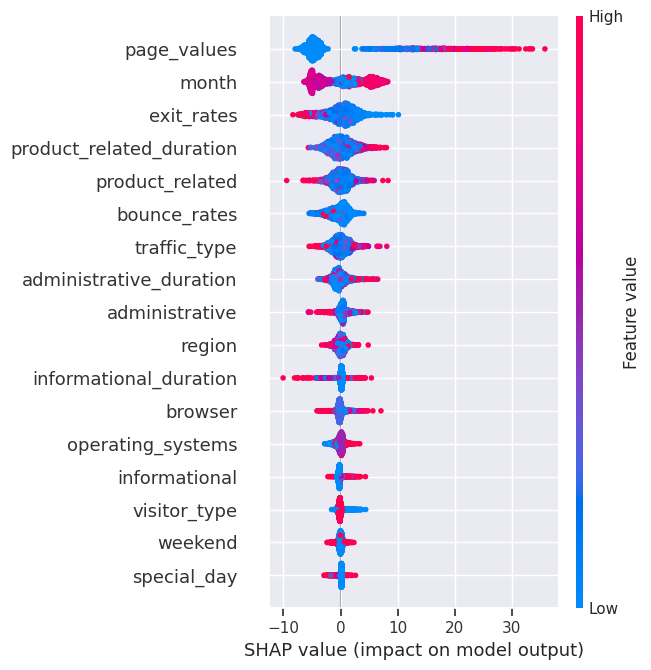

In [67]:
shap.summary_plot(shap_values, X_test)

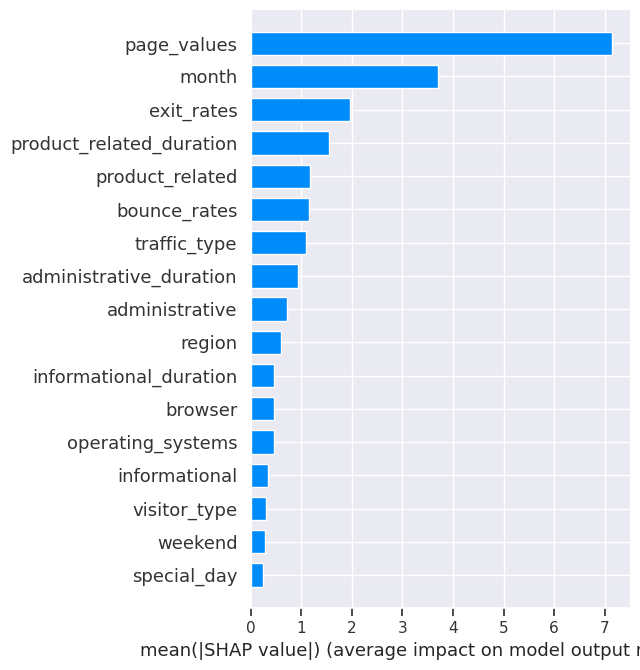

In [68]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

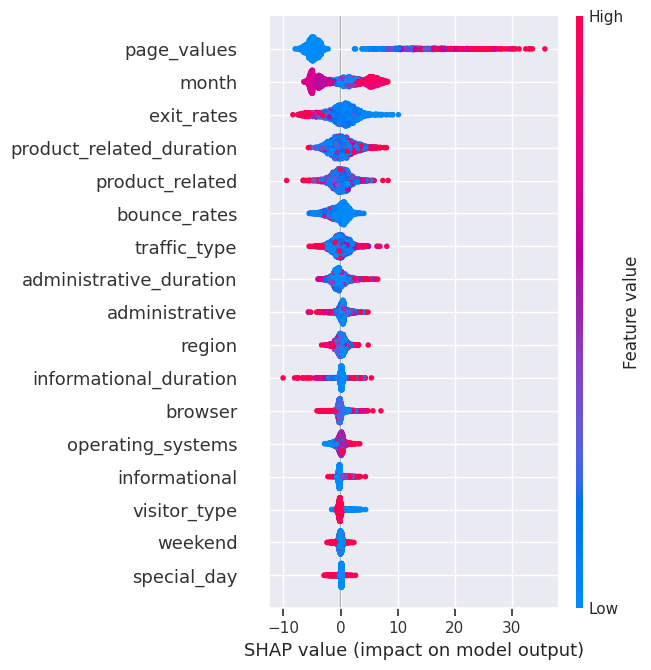

In [69]:
shap.summary_plot(shap_values, X_test.values, feature_names = X.columns)

## IV.1 Dummy Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html  
https://www.youtube.com/watch?v=sGI2QZHOhkM&list=WL&index=2

In [ ]:
# Baseline comparison with Dummy, which returns the mean value of the labels
dummy_classifier = DummyClassifier(strategy="stratified", random_state=22)

start_time = time.time()

# Training
dummy_classifier.fit(X_train, y_train)

fit_time = time.time() - start_time

# Prediction on the test set
y_predict_dummy = dummy_classifier.predict(X_test)

In [ ]:
score_classifier(dummy_classifier, X_train, X_test, y_train, y_test,  fit_time=fit_time)

In [ ]:
plot_confusion_matrix(y_test, y_predict_dummy, title=f"Confusion Matrix: {type(dummy_classifier).__name__}", 
                      figsize=(4, 4), cmap="RdPu", annot=True, fmt="d", annot_kws={"size": 10})

In [ ]:
plot_roc_auc_curve(dummy_classifier, X_test, y_test, title=f"ROC Curve: {type(dummy_classifier).__name__}")

In [ ]:
plot_roc_auc_curve_seaborn(dummy_classifier, X_test, y_test, title=f"ROC Curve: {type(dummy_classifier).__name__}")

# V FEATURE ENGINEERING: Feature Scaling

Real world dataset contains features that highly vary in magnitudes, units, and range. Normalization should be performed when the scale of a feature is irrelevant or misleading and not should Normalize when the scale is meaningful.

The algorithms which use Euclidean Distance measure are sensitive to Magnitudes. Here feature scaling helps to weigh all the features equally.

Formally, If a feature in the dataset is big in scale compared to others then in algorithms where Euclidean distance is measured this big scaled feature becomes dominating and needs to be normalized.

Examples of Algorithms where Feature Scaling matters
1. K-Means uses the Euclidean distance measure here feature scaling matters.
2. K-Nearest-Neighbours also require feature scaling.
3. Principal Component Analysis (PCA): Tries to get the feature with maximum variance, here too feature scaling is required.
4. Gradient Descent: Calculation speed increase as Theta calculation becomes faster after feature scaling. Check this article to undetics Vidhya

Note: Naive Bayes, Linear Discriminant Analysis, and Tree-Based models are not affected by feature scaling.In Short, any Algorithm which is Not Distance based is Not affected by Feature Scaling. It is optional for our problem statement as we will be using Random forest model(you can skip this step)

In [ ]:
model_rf = GradientBoostingClassifier()

In [ ]:
#pipeline = Pipeline(steps=[("transformer", transformer), ("model", model)])

In [ ]:
steps = [('preprocessor', preprocessor),('classifier', model_rf)]

In [ ]:
pipeline = Pipeline(steps=steps)

In [ ]:
XX_transformed = Pipeline(steps=[('preprocessor', preprocessor)]).transform(X_train[:1])

In [ ]:

transformers = pipeline.named_steps['preprocessor'].transformers_
# Initialize an empty list to store transformed feature names
all_feature_names = []

# Loop through each transformer and its corresponding features
for name, trans, features in transformers:
  # If it's the categorical transformer, use get_feature_names_out
  if name == 'cat':
    encoded_names = trans.named_steps['onehot'].get_feature_names_out(input_features=features)
    all_feature_names.extend(encoded_names)
  # If it's the numerical transformer, use the original feature names (no change)
  elif name == 'num':
    all_feature_names.extend(features)
  # Handle other transformers if needed (add logic for their get_feature_names_out behavior)
  else:
    # Handle potential transformers besides categorical and numerical
    pass

# Print or use the all_feature_names list for further analysis
print(all_feature_names)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
print("Training Score:", pipeline.score(X_train, y_train))

In [ ]:
score_classifier(pipeline, X_train, X_test, y_train, y_test)

In [ ]:
plot_roc_auc_curve_seaborn(pipeline, X_test, y_test, title=f"ROC Curve: {type(best_model).__name__}")

In [ ]:
grid_param = {'classifier__n_estimators': [50, 100, 200],
              'classifier__max_depth': [None, 10, 20]}


grid_param_plus = {
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 #"classifier__min_samples_leaf":[1,2,5,10,15,100],
                 #"classifier__max_leaf_nodes": [2, 5,10]
                  }

grid_param_gbc = {'classifier__n_estimators': [50, 100, 150]}

#Gridsearch of the pipeline, the fit the best model
#gridsearch = GridSearchCV(pipeline, grid_param_plus, cv=5, verbose=0,n_jobs=-1) # Fit grid search

gridsearch = GridSearchCV(estimator = pipeline, 
                              param_grid = grid_param_gbc,
                              cv = 5, 
                              verbose = 0,
                              n_jobs = -1, 
                              scoring = 'roc_auc',
                              error_score="raise",
                              refit=True)


best_model = gridsearch.fit(X_train,y_train)

In [ ]:
best_grid_rf = best_model.best_estimator_
best_grid_rf

In [ ]:
best_model.best_score_

In [ ]:
score_classifier(best_model, X_train, X_test, y_train, y_test)

In [ ]:
plot_roc_auc_curve_seaborn(best_model, X_test, y_test, title=f"ROC Curve: {type(best_model).__name__}")

In [ ]:
grid_cv_result(best_model)

In [ ]:
# Get the best model from GridSearchCV
best_grid_rf

# Access the Random Forest classifier from the pipeline using the step name
rf_estimator = best_grid_rf.named_steps['classifier']  # Replace 'rf' with your actual step name
# Get feature importances from the Random Forest classifier
feature_importances = rf_estimator.feature_importances_
feature_names = []
for i,v in enumerate(feature_importances):
    print('Feature: %0d, Score: %.5f' % (i,v))
    feature_names.append(i)

In [ ]:
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])


In [ ]:
transformed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train), 
                                   columns=preprocessor.get_feature_names_out(), 
                                   index=X_train.index)

In [ ]:
feature_names = transformed_X_train.columns.tolist()
feature_names

In [ ]:
# Create a DataFrame from feature names and importances
data = {'Feature': feature_names, 'Score': feature_importances}
df = pd.DataFrame(data)

# Take the absolute value of the score
df['Abs_Score'] = np.abs(df['Score'])

# Sort by absolute value of score in descending order (top 10)
df_top10 = df.sort_values(by="Abs_Score", ascending=False).head(10)

# Define a color palette based on score values (positive = green, negative = red)
colors = ["green" if score > 0 else "red" for score in df_top10["Score"]]

# Create the bar chart with Seaborn
sns.barplot(x="Feature", y="Score", data=df_top10, palette=colors)

# Customize the plot for better visual appeal
plt.xlabel("Feature")
plt.ylabel("Feature Importance Score")
plt.title("Feature Importance in Supervised Classification")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [ ]:
print(transformed_names)

In [ ]:
class MarketingResponsePredictor:
    def __init__(self, data, target_column, categorical_features, numerical_features, boolean_features,
                test_size=0.3, stratify_target=False, enable_hyperparameter_tuning=False, 
                 enable_feature_engineering=False, feature_engineering_method=None, **kwargs):
        self.data = data
        self.target_column = target_column
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.boolean_features = boolean_features
        self.test_size = test_size
        self.stratify_target = stratify_target
        self.enable_hyperparameter_tuning = enable_hyperparameter_tuning
        self.enable_feature_engineering = enable_feature_engineering
        self.feature_engineering_method = feature_engineering_method
        self.kwargs = kwargs
        self.preprocessor = None  # To be initialized during preprocessing

    def preprocess_data(self):
        # Split data into features and target
        X = self.data.drop(columns=[self.target_column])
        y = self.data[self.target_column]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                          stratify=y if self.stratify_target else None,
                                                          random_state=42)

        # Define transformers for different feature types
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        #boolean_transformer = Pipeline(steps=[
        #    ('imputer', SimpleImputer(strategy='constant', fill_value=False))
        #])

        # Create a column transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', categorical_transformer, self.categorical_features),
                ('num', numerical_transformer, self.numerical_features),
                #('bool', boolean_transformer, self.boolean_features)
            ])

        return X_train, X_test, y_train, y_test, preprocessor

    def build_pipeline(self, classifier, pca_components):
        steps = [
            ('preprocessor', self.preprocessor),
            ('classifier', classifier)
        ]

        if self.feature_engineering_method == 'dimensionality_reduction':
            steps.insert(1, ('pca', PCA(n_components=pca_components)))

        return Pipeline(steps)

    def hyperparameter_tuning(self, pipeline, param_grid):
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        return grid_search

    def evaluate_model(self, model, X_test, y_test):
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        confusion_matrix_clf = cm.tolist()
        return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1,
                        "true_pos" : confusion_matrix_clf[1][1],
                        "true_neg" : confusion_matrix_clf[0][0],
                        "false_pos" : confusion_matrix_clf[0][1],
                        "false_neg" : confusion_matrix_clf[1][0]
               }

    def test_classifier(self, classifier, X_train, X_test, y_train, y_test, hyperparameter_grid=None):
        
        # Build pipeline
        pca_components = self.kwargs.get('pca_components', 5)
        pipeline = self.build_pipeline(classifier, pca_components)

        # Handle hyperparameter tuning and feature engineering if enabled
        if self.enable_hyperparameter_tuning:
            grid_search = self.hyperparameter_tuning(pipeline, hyperparameter_grid)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            pipeline.fit(X_train, y_train)
            best_model = classifier

        # Evaluate model
        return self.evaluate_model(best_model, X_test, y_test)

   
    def test_classifiers(self):
        # Preprocess the data
        X_train, X_test, y_train, y_test, self.preprocessor = self.preprocess_data()

        
        # Test and print results for each classifier
        classifer_param_grid = self.kwargs.get('classifer_param_grid', {})
        print("classifer_param_grid:", classifer_param_grid)
        results = {}
        for name, (classifier, param_grid) in classifer_param_grid.items():
            print("\nname:", name)
            print("classifier:", classifier)
            print("param_grid:", param_grid)
            result = self.test_classifier(classifier, X_train, X_test, y_train, y_test, hyperparameter_grid=param_grid)
            results[name] = result

        # Display results
        results_df = pd.DataFrame(results).T
        return results_df

In [ ]:
def rename_to_snake_case(df):
 """
 Renames the columns of a DataFrame to snake_case, handling camel case, acronyms, Pascal case, hyphens, and multiple spaces.
 Args:
     df: The DataFrame to rename.
 Returns:
     A new DataFrame with the columns renamed to snake_case.
 """
 return df.rename(columns=lambda s: '_'.join([word.lower() for word in re.findall(r'[A-Z][a-z]*', s.replace('-', '_').replace('  ', '_'))]))

In [ ]:
# Load the dataset
data_path = "https://raw.githubusercontent.com/donadviser/datasets/master/data-don/online_shoppers_intention.csv"
data = pd.read_csv(data_path)
df = (data
      .pipe(rename_to_snake_case)
      # Drop duplicates
      .drop_duplicates()
     )

In [ ]:
df.columns

In [ ]:
# Example Usage:
# Assuming 'df' is your DataFrame and 'response' is the target column
categorical_features = ["operating_systems", "browser", "region", "traffic_type", "visitor_type", "month", "weekend"]
boolean_features = ["weekend"]
numerical_features = df.drop(["revenue"], axis=1).columns.difference(categorical_features)
target_column = "revenue"

# Classifiers and their hyperparameter tuning grids
classifer_param_grid = {
    'RandomForest': (RandomForestClassifier(), {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20]}),
    'GradientBoosting': (GradientBoostingClassifier(), {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]}),
    'LogisticRegression': (LogisticRegression(), {'classifier__C': [0.1, 1, 10], 'classifier__penalty': ['l1', 'l2']}),
    'SVM': (SVC(), {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}),
    'KNeighbors': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7], 'classifier__weights': ['uniform', 'distance']}),
    'DecisionTree': (DecisionTreeClassifier(), {'classifier__max_depth': [None, 10, 20], 'classifier__min_samples_split': [2, 5, 10]})
}

marketing_respose = MarketingResponsePredictor(df, target_column, categorical_features,
                                       numerical_features, boolean_features,
                                       test_size=0.2, stratify_target=True,
                                       enable_hyperparameter_tuning=True,
                                       enable_feature_engineering=True,
                                       feature_engineering_method='dimensionality_reduction',
                                       pca_components=5, classifer_param_grid=classifer_param_grid)



In [ ]:
predicted_results = marketing_respose.test_classifiers()

In [ ]:
predicted_results.sort_values(by="F1-Score", ascending=False)

In [ ]:
for name, (classifier, hyperparameter_grid) in classifiers.items():
    best_model, accuracy, precision, recall, f1 = predictor.train_and_test(classifier,
                                                                           hyperparameter_grid=hyperparameter_grid,
                                                                           pca_components=5)

    print(f"\nResults for {name} Classifier:")
    print("Best Model:", best_model)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


In [ ]:
print("a", ["b"]+["c"])

In [ ]:
steps = [
            ('preprocessor', "self.preprocessor"),
            ('classifier', "classifier")
        ]

In [ ]:
steps

In [ ]:
steps.insert(1, ('pca', "n_components"))

In [ ]:
steps

In [ ]:
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import Imputer
from sklearn.model_selection import StratifiedKFold

In [ ]:
pipe_svc = make_pipeline(SimpleImputer(),StandardScaler(),PCA(n_components=10),SVC(probability=True, random_state=1))
#pipe_svc = make_pipeline(SimpleImputer(),StandardScaler(),SVC(probability=True, random_state=1))
#'SVC': (SVC(probability=True, random_state=42), {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}),


param_grid = {'svc__C': [0.01,0.1,1,10], 'svc__kernel': ['linear', 'rbf'],
             # 'svc__gamma': [0.001,0.01,0.1,1,10,100,1000]
             }

In [ ]:
cv = StratifiedKFold(n_splits=5)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid, scoring='accuracy', cv = cv,n_jobs = -1,
                  verbose = 0,return_train_score=True,refit=True)

In [ ]:
gs.fit(X_train, y_train)

print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print("Best Training Score: \n{}\n".format(gs.cv_results_['mean_train_score'][gs.best_index_]))
print("All Training Scores: \n{}\n".format(gs.cv_results_['mean_train_score']))

In [ ]:
test_scores = score_classifier(gs.best_estimator_, X_train, X_test, y_train, y_test, fit_time=None)

In [ ]:
pca=0

In [ ]:
test_scores = score_classifier(gs.best_estimator_, X_train, X_test, y_train, y_test, fit_time=None)

In [ ]:
 
 pca = 5

In [ ]:
test_scores = score_classifier(gs.best_estimator_, X_train, X_test, y_train, y_test, fit_time=None)